In [2]:
import glob
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

from qiskit import *
from qiskit.quantum_info import Statevector

import dqva

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa, dqv_ansatz, qls_ansatz, dqv_cut_ansatz
from networkx.algorithms.approximation.independent_set import maximum_independent_set

matplotlib.rc('xtick', labelsize=18)     
matplotlib.rc('ytick', labelsize=18)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
test_graphs = glob.glob('benchmark_graphs/N6_p20_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

50


benchmark_graphs/N6_p20_graphs/G2.txt
Optimal: ('000111', 3)


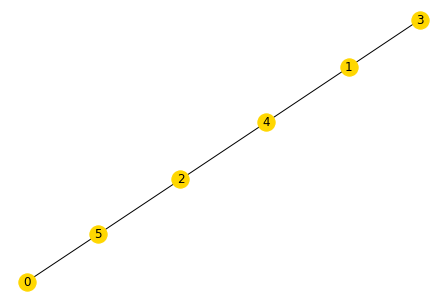

In [3]:
graph = test_graphs[1]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [4]:
len(maximum_independent_set(G))

3

In [8]:
sample_graphs = test_graphs[0:1]
print(len(sample_graphs))
print(sample_graphs)

1
['benchmark_graphs/N6_p20_graphs/G1.txt']


In [9]:
qaoa_data = {}
qlsa_data = {}

for graph_name in sample_graphs:
    print(graph_name)
    G = graph_from_file(graph_name)
    nq = len(G.nodes())
    opt_mis = brute_force_search(G)[1]
    
    init_state = '0'*nq
    mixer_order = list(range(nq))
    
    graph_key = graph_name.split('/')[-1].strip('.txt')
    graph_qaoa_data = []
    graph_qlsa_data = []
    
    print('\n\nBEGIN QAOA\n\n')
    
    for P in [1,2]:
        output = dqva.solve_mis_qaoa(init_state, G, P=P, mixer_order=mixer_order, sim='qasm')
        ap_ratio = hamming_weight(output[0]) / opt_mis
        mixer_count = nq * P
        print('-'*30)
        print('Found approximation ratio = {}, with {} partial_mixers'.format(ap_ratio, mixer_count))
        print('-'*30)
        graph_qaoa_data.append((mixer_count, ap_ratio))
    
    qaoa_data[graph_key] = graph_qaoa_data
    
    print('\n\nBEGIN QLS\n\n')

    for plim in [2, 4]:
        output = dqva.solve_mis_qls(init_state, G, m=5, mixer_order=mixer_order, sim='qasm', param_lim=plim)
        ap_ratio = hamming_weight(output[0]) / opt_mis
        mixer_count = plim - 1
        print('-'*30)
        print('Found approximation ratio = {}, with {} partial_mixers'.format(ap_ratio, mixer_count))
        print('-'*30)
        graph_qlsa_data.append((mixer_count, ap_ratio))
        
    qlsa_data[graph_key] = graph_qlsa_data

benchmark_graphs/N6_p20_graphs/G1.txt


BEGIN QAOA


Start round 1.1, Initial state = 000000
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -2.0
	Found new independent set: 001001, Hamming weight = 2
Start round 1.2, Initial state = 001001
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -2.9998779296875
	Found new independent set: 110100, Hamming weight = 3
Start round 1.3, Initial state = 110100
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -3.0
	None of the measured bitstrings had higher Hamming weight than: 110100
	RETURNING, best hamming weight: 3
------------------------------
Found approximation ratio = 1.0, with 6 partial_mixers
------------------------------
Start round 1.1, Initial state = 000000
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5]
	Optimal cost: -1.997314453125
	Found new independent set: 001001, Hamming weight = 2
Start round 1.2, Initial state = 001001
	Num params = 4
	Current Mi

In [10]:
print(qaoa_data)
print(qlsa_data)

{'G1': [(6, 1.0), (12, 1.0)]}
{'G1': [(1, 0.6666666666666666), (3, 1.0)]}


In [3]:
def plot_comparison(qaoa_data, qlsa_data, savefig=False, show=True, classical_approx=None):
    assert(list(qaoa_data.keys()) == list(qlsa_data.keys()))
    
    for graph in qaoa_data.keys():
        
        fig, ax = plt.subplots(dpi=150)
        
        for dat, label in zip([qaoa_data, qlsa_data], ['QAOA', 'QLS']):
            xvals = [tup[0] for tup in dat[graph]]
            yvals = [tup[1] for tup in dat[graph]]
            print(label)
            print(xvals)
            print(yvals)
        
            ax.plot(xvals, yvals, label=label)
            
        if not classical_approx is None:
            for approx in classical_approx:
                ax.axhline(y=approx[0], label=approx[1], ls='--', c=approx[2])
        
        ax.set_title(graph)
        ax.legend()
        ax.set_ylabel('Approximation Ratio')
        ax.set_xlabel('Number of partial mixers')
        
        if show:
            plt.show()
        
        
        savestr = '_'.join([a for a in graph.split() if a != '='])
        print(savestr)
        if savefig:
            plt.savefig('figures/avg_erdosrenyi/'+savestr+'.png')
            
        plt.close()

QAOA
[6, 12]
[1.0, 1.0]
QLS
[1, 3]
[0.6666666666666666, 1.0]


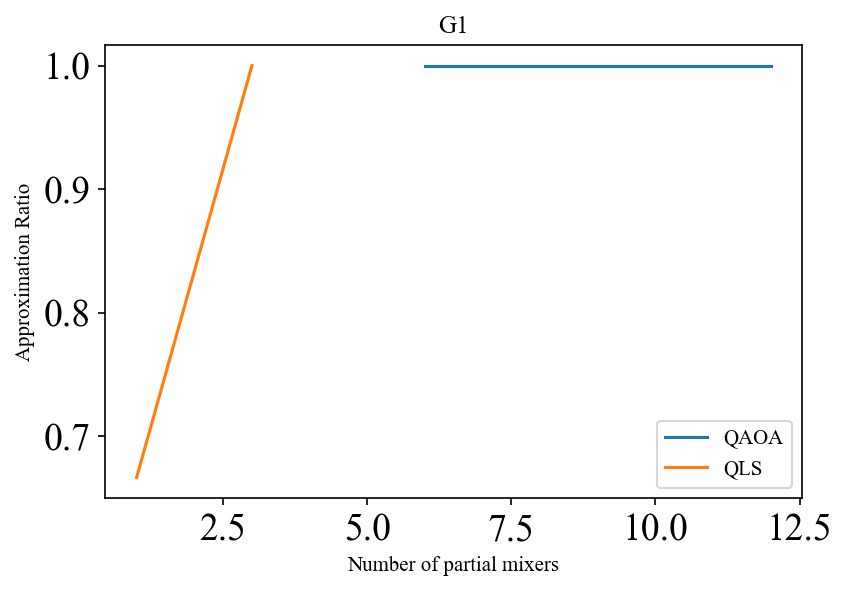

G1


In [12]:
plot_comparison(qaoa_data, qlsa_data)

In [13]:
all_x = []
all_y = []
for key, data in qaoa_data.items():
    all_x.append([v[0] for v in data])
    all_y.append([v[1] for v in data])
all_x = np.mean(all_x, axis=0)
all_y = np.mean(all_y, axis=0)
avg_qaoa_data = {'Avg Erdos-Renyi N=12':list(zip(all_x, all_y))}

all_x = []
all_y = []
for key, data in qlsa_data.items():
    all_x.append([v[0] for v in data])
    all_y.append([v[1] for v in data])
all_x = np.mean(all_x, axis=0)
all_y = np.mean(all_y, axis=0)
avg_qlsa_data = {'Avg Erdos-Renyi N=12':list(zip(all_x, all_y))}

print(avg_qaoa_data)
print(avg_qlsa_data)

{'Avg Erdos-Renyi N=12': [(6.0, 1.0), (12.0, 1.0)]}
{'Avg Erdos-Renyi N=12': [(1.0, 0.6666666666666666), (3.0, 1.0)]}


QAOA
[6.0, 12.0]
[1.0, 1.0]
QLS
[1.0, 3.0]
[0.6666666666666666, 1.0]


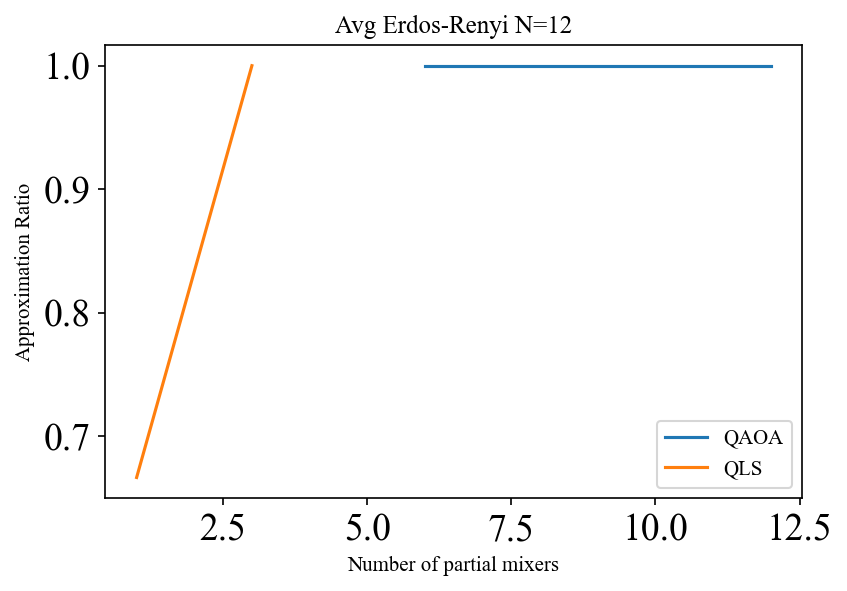

Avg_Erdos-Renyi_N=12


In [14]:
plot_comparison(avg_qaoa_data, avg_qlsa_data)

## Load and plot benchmarks

In [8]:
def load_cls_data(graph_fn):
    cls_ratios = []
    
    cls_res_fn = glob.glob('CutBranching/Output/'+graph_fn+'/*')[0]
    #print(cls_res_fn)
    
    with open(cls_res_fn, 'r') as cls_file:
        for line in cls_file:
            mis_size = int(line.split()[-1])
            graph = line.split()[1]
            with open('CutBranching/Input/'+graph_fn+'/'+graph, 'r') as input_file:
                for i, input_line in enumerate(input_file):
                    if i == 1:
                        opt_mis = int(input_line.split()[-1].strip(')'))
                    if i > 0:
                        break
            #print(graph, mis_size, '<=', opt_mis, '=', mis_size <= opt_mis)
            
            if mis_size > opt_mis:
                raise Exception('CLS found MIS > OPT!')
            
            cls_ratios.append(mis_size / opt_mis)
            
    
    return cls_ratios

In [5]:
def load_data(graph_fn):
    
    # Load the qlsa data
    qlsa_y_data = []
    
    graphs = glob.glob('benchmark_results/qlsa_P1_qasm/'+graph_fn+'/*')
    lims = [int(fn.split('_')[-3].strip('lim')) for fn in glob.glob(graphs[0]+'/*')]
    lims = list(sorted(set(lims)))
    print('qlsa lims:', lims)
    
    for graph_dir in graphs:        
        # get the optimal MIS
        with open(glob.glob(graph_dir+'/*{}*rep1.pickle'.format(lims[0]))[0], 'rb') as pklfile:
            output = pickle.load(pklfile)
        graph_name = '/'.join(output['graph'].split('/')[-3:])
        G = graph_from_file(graph_name)
        nq = len(G.nodes())
        opt_mis = brute_force_search(G)[1]
        
        cur_graph_data = []
        for val in lims:
            reps = glob.glob(graph_dir+'/*{}*rep*.pickle'.format(val))
            cur_val_data = []
            for rep in reps:
                with open(rep, 'rb') as pklfile:
                    output = pickle.load(pklfile)
                    cur_mis = output['out'][0]
                    cur_val_data.append(hamming_weight(cur_mis) / opt_mis)
            cur_graph_data.append(np.mean(cur_val_data))
        qlsa_y_data.append(cur_graph_data)
    
    # The averaged results for each graph is stored in the qlsa_y_data list
    qlsa_xvals = []
    for lim in lims:
        if lim // (nq + 1) <= 1:
            num_phase_sep = 1
        else:
            num_phase_sep = lim // (nq + 1)
        qlsa_xvals.append(lim-num_phase_sep)
        
    qlsa_data = {'x':qlsa_xvals, 'y':qlsa_y_data}
    
    
    # Load the qaoa data
    qaoa_y_data = []
    
    algs = glob.glob('benchmark_results/qaoa_P*_qasm')
    algs = sorted(algs, key=lambda a: int(a.split('_')[-2].strip('P')))
    
    pvals = [int(fn.split('_')[-2].strip('P')) for fn in algs]
    pvals = list(sorted(set(pvals)))
    print('qaoa pvals:', pvals)
    
    graphs = [g.split('/')[-1] for g in glob.glob(algs[0]+'/'+graph_fn+'/*')]
    graphs = sorted(graphs, key=lambda g: int(g.strip('G.txt')))
    
    # collect classical MIS data at the same time
    classical_data = {}
    temp_classical_data = []
    for graph in graphs:        
        with open(glob.glob(algs[0]+'/'+graph_fn+'/'+graph+'/*')[0], 'rb') as pklfile:
            output = pickle.load(pklfile)
        graph_name = '/'.join(output['graph'].split('/')[-3:])
        G = graph_from_file(graph_name)
        nq = len(G.nodes())
        opt_mis = brute_force_search(G)[1]
        
        # Find MIS with Boppana-Halldorsson
        classical_approx = len(maximum_independent_set(G)) / opt_mis
        temp_classical_data.append(classical_approx)
        
        cur_graph_data = []
        for alg in algs:
            reps = glob.glob(alg+'/'+graph_fn+'/'+graph+'/*')
            cur_alg_data = []
            for rep in reps:
                with open(rep, 'rb') as pklfile:
                    output = pickle.load(pklfile)
                    cur_mis = output['out'][0]
                    cur_alg_data.append(hamming_weight(cur_mis) / opt_mis)
            cur_graph_data.append(np.mean(cur_alg_data))
        
        if not any(np.isnan(np.array(cur_graph_data))):
            qaoa_y_data.append(cur_graph_data)
    
    # Save Boppana-Halldorsson results
    classical_data['BH'] = temp_classical_data
        
    # The averaged results for each graph is stored in the qaoa_y_data list
    qaoa_xvals = [p*nq for p in pvals]
    qaoa_data = {'x':qaoa_xvals, 'y':qaoa_y_data}
    
    # Load the classical local search data
    classical_data['CLS'] = load_cls_data(graph_fn)
            
    return qlsa_data, qaoa_data, classical_data

N10_p20_graphs
qlsa lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=10, p=20%)': [(1, 0.7398285714285714), (3, 0.8664761904761907), (5, 0.936171428571429), (15, 0.9846)]}
{'Avg Erdos-Renyi (N=10, p=20%)': [(10, 0.9101333333333337), (20, 0.9048476190476193), (30, 0.9152285714285715)]}
Avg Boppana-Halldorsson approximation: 0.9028095238095236
Avg CLS approximation: 1.0
QAOA
[10, 20, 30]
[0.9101333333333337, 0.9048476190476193, 0.9152285714285715]
QLS
[1, 3, 5, 15]
[0.7398285714285714, 0.8664761904761907, 0.936171428571429, 0.9846]


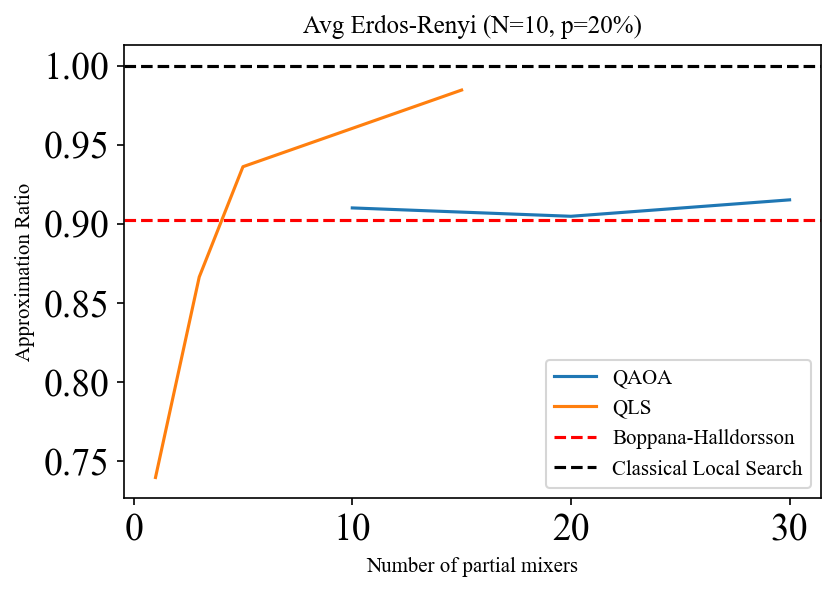

Avg_Erdos-Renyi_(N=10,_p=20%)
N6_p80_graphs
qlsa lims: [16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=6, p=80%)': [(14, 0.9986666666666667)]}
{'Avg Erdos-Renyi (N=6, p=80%)': [(6, 0.9619999999999999), (12, 0.9786666666666668), (18, 0.9840000000000001)]}
Avg Boppana-Halldorsson approximation: 0.9866666666666666
Avg CLS approximation: 1.0
QAOA
[6, 12, 18]
[0.9619999999999999, 0.9786666666666668, 0.9840000000000001]
QLS
[14]
[0.9986666666666667]


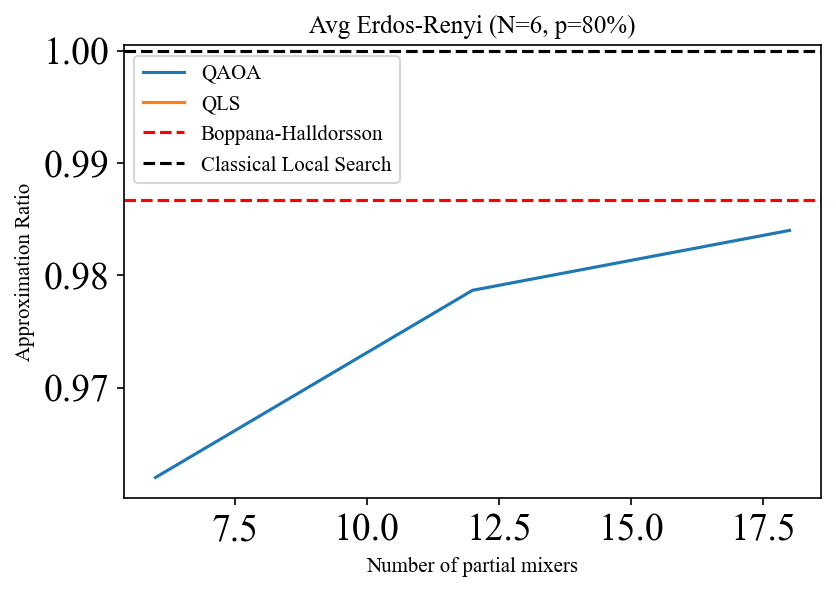

Avg_Erdos-Renyi_(N=6,_p=80%)
N12_p80_graphs
qlsa lims: [16]
qaoa pvals: [1, 2, 3]
{'Avg Erdos-Renyi (N=12, p=80%)': [(15, 0.9406666666666668)]}
{'Avg Erdos-Renyi (N=12, p=80%)': [(12, 0.8663333333333334), (24, 0.8646666666666667), (36, 0.8933333333333333)]}
Avg Boppana-Halldorsson approximation: 0.9266666666666667
Avg CLS approximation: 1.0
QAOA
[12, 24, 36]
[0.8663333333333334, 0.8646666666666667, 0.8933333333333333]
QLS
[15]
[0.9406666666666668]


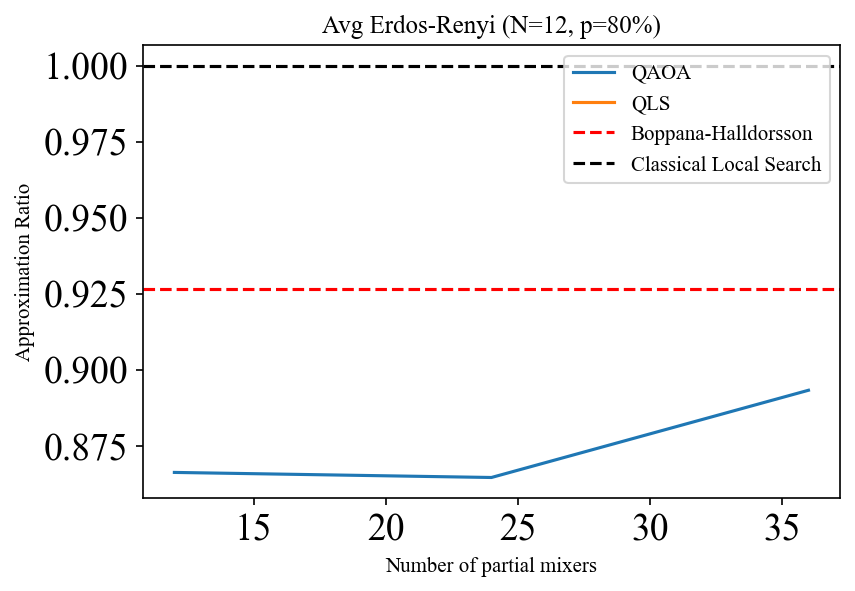

Avg_Erdos-Renyi_(N=12,_p=80%)


In [38]:
graphs = glob.glob('benchmark_results/qaoa_P1_qasm/*')
graphs = [g.split('/')[-1] for g in graphs]
for graph in graphs[0:3]:
    print(graph)
    name = 'Avg Erdos-Renyi (N={}, p={}%)'.format(graph.split('_')[0].strip('N'),
                                                 graph.split('_')[1].strip('p'))
    
    qlsa_data, qaoa_data, classical_data = load_data(graph)
    avg_qlsa_data = {name:list(zip(qlsa_data['x'], np.mean(np.array(qlsa_data['y']), axis=0)))}
    avg_qaoa_data = {name:list(zip(qaoa_data['x'], np.mean(np.array(qaoa_data['y']), axis=0)))}
    avg_bh_approx = np.mean(classical_data['BH'])
    avg_cls_approx = np.mean(classical_data['CLS'])
    print(avg_qlsa_data)
    print(avg_qaoa_data)
    print('Avg Boppana-Halldorsson approximation:', avg_bh_approx)
    print('Avg CLS approximation:', avg_cls_approx)
    
    classical_approxs = [(avg_bh_approx, 'Boppana-Halldorsson', 'r'),
                         (avg_cls_approx, 'Classical Local Search', 'k')]
    
    plot_comparison(avg_qaoa_data, avg_qlsa_data, savefig=False, show=True, classical_approx=classical_approxs)

In [6]:
def plot_comp_fig(fig_data, savestr=None, show=True):
    num_plots = len(fig_data)
    fig, ax = plt.subplots(dpi=150, figsize=[18,9], nrows=2, ncols=int(num_plots/2), sharey='row')
    
    for i, dat in enumerate(fig_data):
        cur_ax = ax[i // int(num_plots / 2), i % int(num_plots / 2)]
        
        qlsa_data = dat[1]
        qaoa_data = dat[2]
        classical_approx = dat[3]
        graph = list(qlsa_data.keys())[0]
        
        if graph == 'Avg Erdos-Renyi (N=16, p=50%)':
            print(graph)
        
        for approx in classical_approx:
            cur_ax.axhline(y=approx[0], label=approx[1], ls='--', c=approx[2])
        
        for dat, label, color in zip([qaoa_data, qlsa_data], ['QAOA', 'QLS'], ['tab:orange', 'tab:blue']):
            xvals = [tup[0] for tup in dat[graph]]
            yvals = [tup[1] for tup in dat[graph]]
            stdvs = [tup[2] for tup in dat[graph]]
            
            if graph == 'Avg Erdos-Renyi (N=16, p=50%)':
                print('xvals:', xvals)
                print('yvals:', yvals)
        
            #cur_ax.plot(xvals, yvals, label=label)
            #print(stdvs)
            cur_ax.errorbar(xvals, yvals, yerr=stdvs, label=label, fmt='o', capsize=4, ms=8, c=color)
        
        
        cur_ax.set_title(graph, fontsize=18)
    
    ax[0,0].legend(fontsize=18)
    for i in [0,1]:
        ax[i,0].set_ylabel('Approximation Ratio', fontsize=18)
    for i in [0,1,2]:
        ax[1,i].set_xlabel('Number of partial mixers', fontsize=18)
    plt.tight_layout()
    
    if not savestr is None:
        plt.savefig(savestr)
        
    if show:
        plt.show()

    plt.close()

In [9]:
# Plotting paper figure
graphs = ['N8_p20_graphs', 'N12_p20_graphs', 'N16_p20_graphs',
          'N8_p50_graphs', 'N12_p50_graphs', 'N16_p50_graphs']

figure_data = []
for graph in graphs:
    name = 'Avg Erdos-Renyi (N={}, p={}%)'.format(graph.split('_')[0].strip('N'),
                                                 graph.split('_')[1].strip('p'))
    
    qlsa_data, qaoa_data, classical_data = load_data(graph)
    avg_qlsa_data = {name:list(zip(qlsa_data['x'], np.mean(np.array(qlsa_data['y']), axis=0),
                                                   np.std(np.array(qlsa_data['y']), axis=0)))}
    avg_qaoa_data = {name:list(zip(qaoa_data['x'], np.mean(np.array(qaoa_data['y']), axis=0),
                                                   np.std(np.array(qaoa_data['y']), axis=0)))}
    avg_bh_approx = np.mean(classical_data['BH'])
    avg_cls_approx = np.mean(classical_data['CLS'])
    avg_classical_approx = [(avg_bh_approx, 'Boppana-Halldorsson', 'grey'),
                            (avg_cls_approx, 'Classical Local Search', 'red')]
    
    figure_data.append((graph, avg_qlsa_data, avg_qaoa_data, avg_classical_approx))

qlsa lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
qlsa lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
qlsa lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
qlsa lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
qlsa lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]
qlsa lims: [2, 4, 6, 16]
qaoa pvals: [1, 2, 3]


/Users/teague/qEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/teague/qEnv/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Avg Erdos-Renyi (N=16, p=50%)
xvals: [16, 32, 48]
yvals: [0.845925925925926, 0.8443703703703703, 0.8577777777777775]
xvals: [1, 3, 5, 15]
yvals: [0.58565, 0.7358666666666666, 0.8600666666666666, 0.9249000000000003]


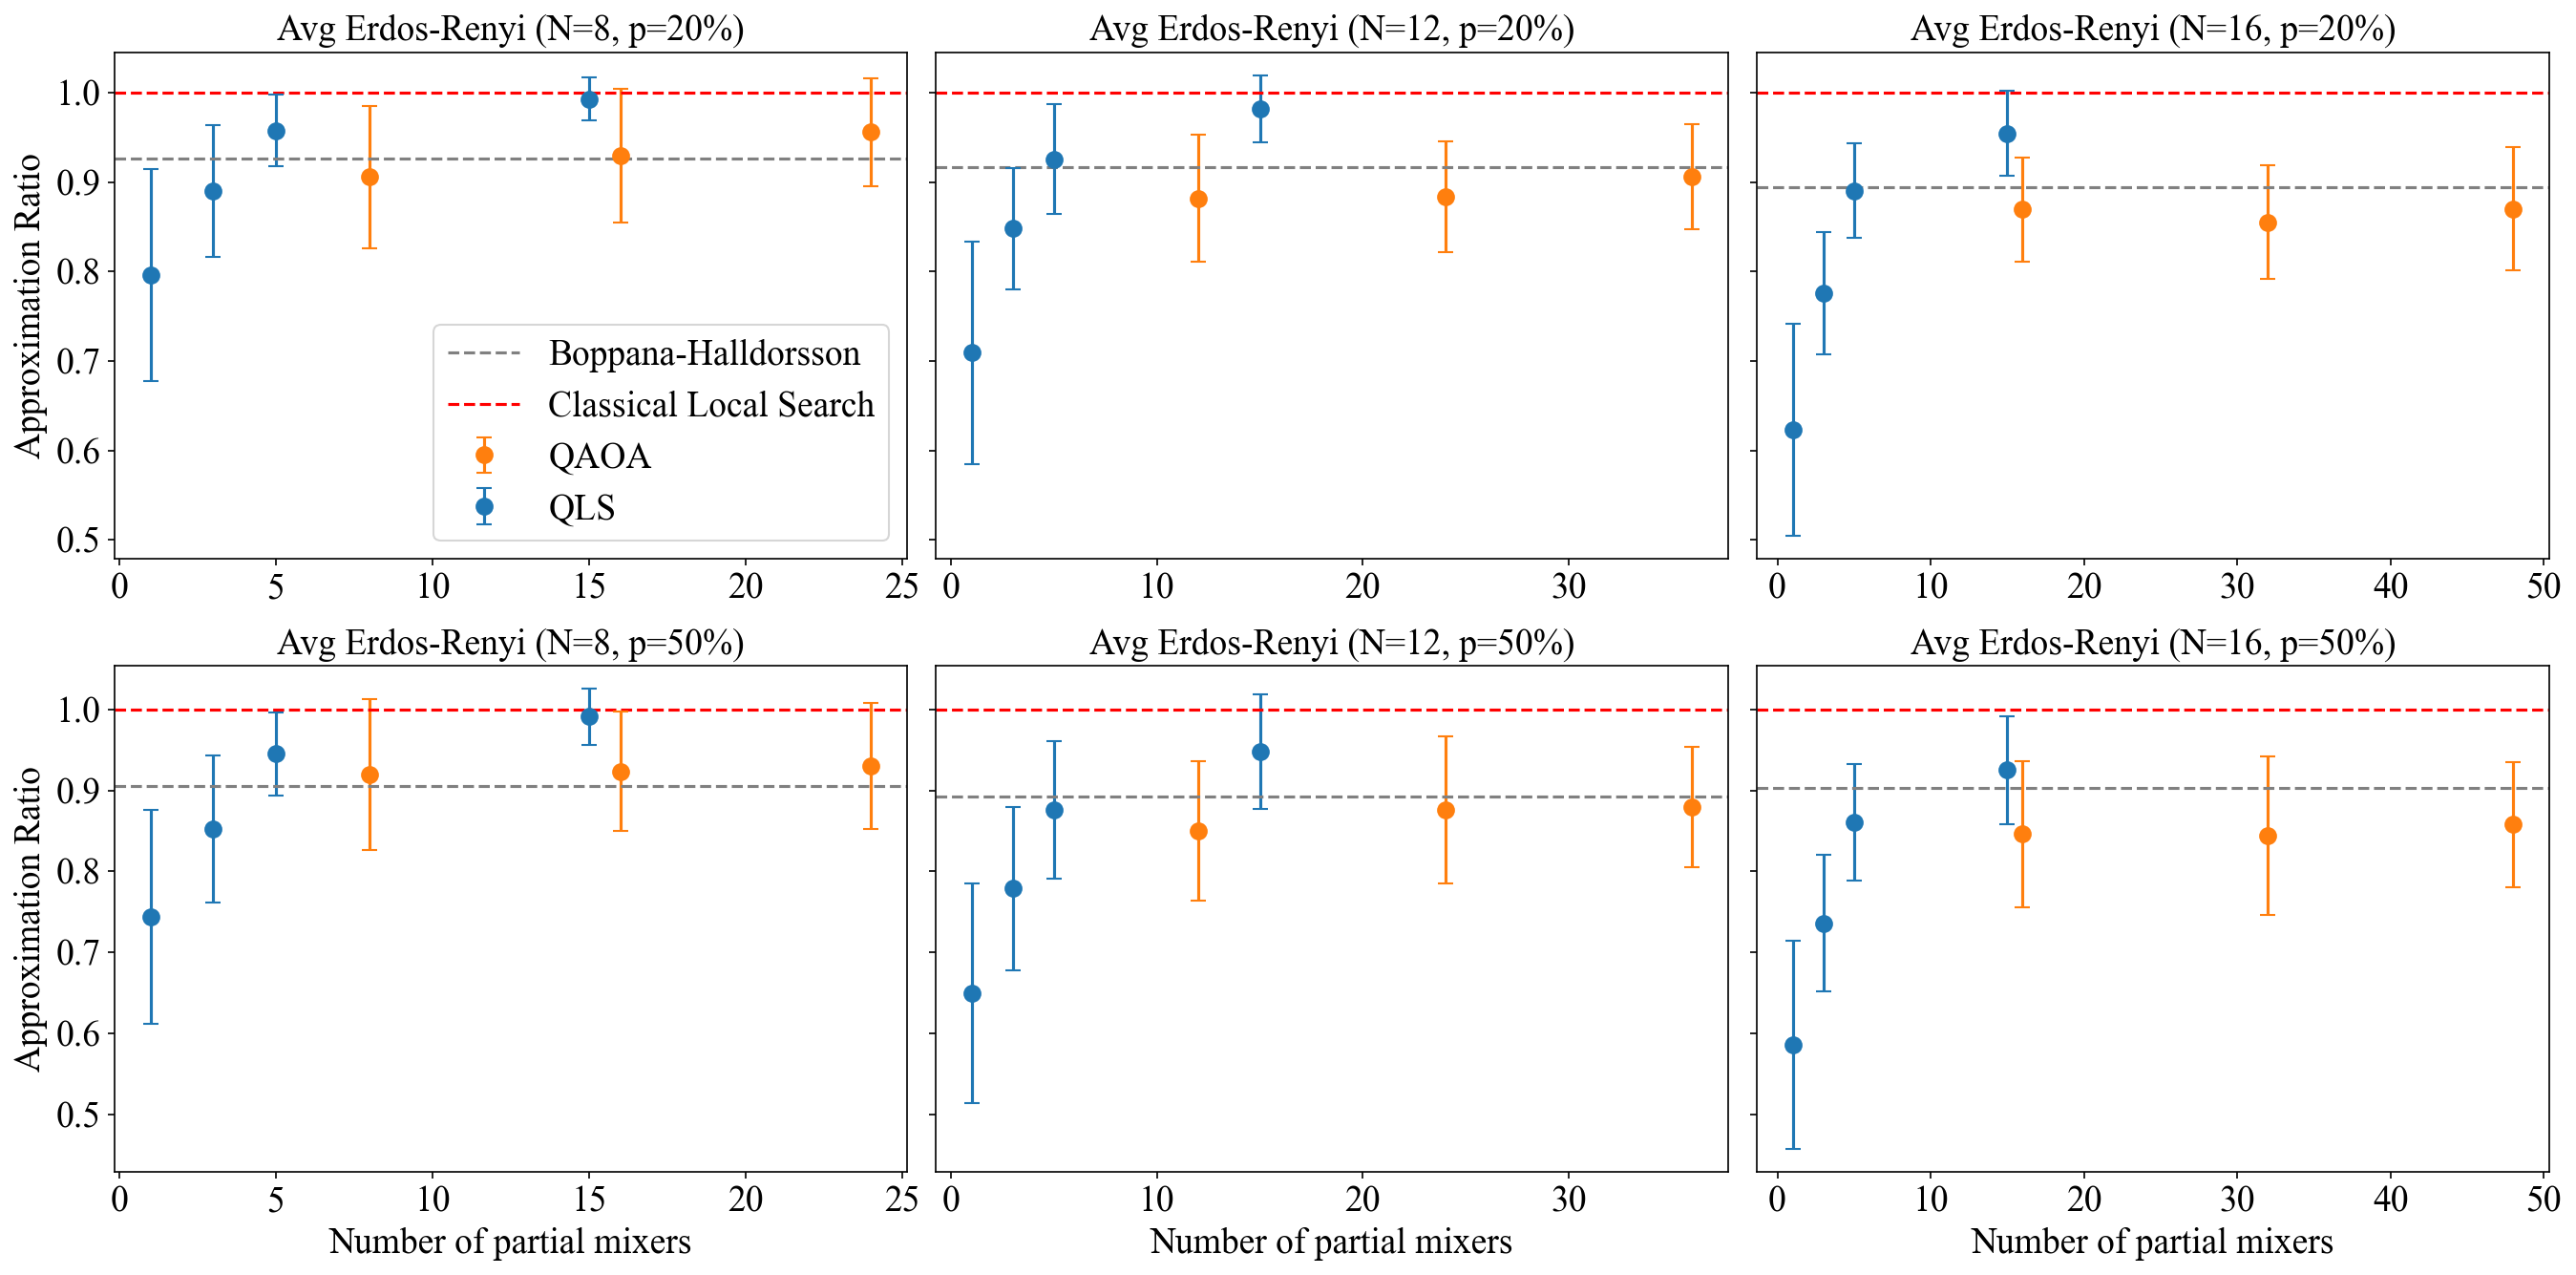

In [11]:
savestr = 'figures/combined_erdosrenyi.png'
plot_comp_fig(figure_data, savestr=savestr)